# Putting It All Together (Part 1)

The objective of this Python notebook is to demonstrate how the various elements of our research can be integrated to achieve the following research goals:
- Finding Similar Scam Reports
- Generating Key Terms from Similar Scam Reports
- Classifying Scam Reports

## Import the necessarary libraries

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy.matcher import Matcher
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import networkx as nx
import re
import math
import plotly.express as px
%matplotlib inline
import warnings
warnings.simplefilter("ignore")
%pprint

nlp = spacy.load('en_core_web_sm')

Pretty printing has been turned OFF


## Define function

In [3]:
def read_csv(path):
    
    """This function reads a CSV file from a specified filepath, while preserving the data types of each variable.
    Source: https://stackoverflow.com/questions/50047237/how-to-preserve-dtypes-of-dataframes-when-using-to-csv/50051542#50051542"""
    
    # Read types first line of csv
    dtypes = {key:value for (key,value) in pd.read_csv(path, nrows=1).iloc[0].to_dict().items() if 'date' not in value}

    parse_dates = [key for (key,value) in pd.read_csv(path, 
                   nrows=1).iloc[0].to_dict().items() if 'date' in value]
    
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, parse_dates=parse_dates, skiprows=[1])

In [4]:
def get_noun_phrases(sent):
    
    """This function takes a text string as input, and returns a list of noun phrases extracted from the text string"""
    
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)  
    pattern_1 = [{"POS": "NOUN", "OP": "+"}]
    pattern_2 = [{"POS": "ADJ"}, {"POS": "NOUN", "OP": "+"}]
    matcher.add("Noun_phrases", None, pattern_1, pattern_2)
    matches = matcher(doc)

    span = []
    for match_id, start, end in matches:
        span.append(doc[start:end].text)

    return span

In [5]:
def get_jaccard_sim(str1, str2): 
    
    """This function takes two lists of tokens as inputs and computes the Jaccard similarity between them."""
    
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    
    return float(len(c)) / (len(a) + len(b) - len(c))

In [6]:
def find_similar_docs_cosine_jaccard(model, corpus, tag_id=None, new_doc=None, top_n=10):    
    
    """This function takes a Doc2Vec model, corpus and tag ID as inputs and 
    returns a dataframe with the most similar documents and their cosine and 
    Jaccard similarity scores."""

    if isinstance(top_n, int) == True:
        n = top_n
    elif isinstance(top_n, float) == True:
        n = round(top_n * len(model.docvecs))
             
    if tag_id is not None:
        infer_vector = model.infer_vector(corpus[tag_id].words)
        print(infer_vector)
        candidate_sentence = ' '.join(corpus[tag_id].words).replace('< ', '<').replace(' >', '>').replace(' ,', ',').replace(' .', '.')
        candidate_noun_phrases = get_noun_phrases(candidate_sentence)
    elif new_doc is not None:
        infer_vector = model.infer_vector(word_tokenize(new_doc.lower()))
        candidate_noun_phrases = get_noun_phrases(new_doc.lower())

    similar_documents = model.docvecs.most_similar([infer_vector], topn = len(model.docvecs))
    
    similarity_scores_list = []
    for i in range(len(model.docvecs)):
        tag = similar_documents[i][0]
        sent = ' '.join(corpus[tag].words).replace('< ', '<').replace(' >', '>').replace(' ,', ',').replace(' .', '.')
        sent_noun_phrases = get_noun_phrases(sent)
        similarity_scores_list.append((tag, get_jaccard_sim(candidate_noun_phrases, sent_noun_phrases), similar_documents[i][1], ' '.join(corpus[tag].words).replace('< ', '<').replace(' >', '>').replace(' ,', ',').replace(' .', '.')))
    
                                                   
    return pd.DataFrame(similarity_scores_list, columns=['tag_id', 'jaccard', 'cosine', 'text'])

In [7]:
def documents_without_stopwords(doc_list):

    """This function takes a list of documents as input and returns a list of documents without stop words."""
    
    without_stopwords = []
    for i in range(len(doc_list)):
        sentence_without_stopwords = []
        for word in nltk.word_tokenize(doc_list[i]):
            if not word in set(stop_words):
                sentence_without_stopwords.append(word)
        without_stopwords.append(' '.join(sentence_without_stopwords).replace('< ', '<').replace(' >', '>').replace(' ,', ',').replace(' .', '.'))

    return without_stopwords

In [8]:
def extract_n_grams(doc_list, n_min=1, n_max=1, top_n=20):
    
    """This function takes a list of documents as input, and generates top_n n-grams based on TF-IDF scores. 
    1. For unigrams, select n_min = 1 and n_max = 1;
    2. For bigrams, select n_min = 2 and n_max = 2; 
    3. For trigrams, select n_min = 3 and n_max = 3;
    4. For combination, e.g. unigrams and bigrams, select n_min = 1 and n_max = 2."""
    
    vectorizer = TfidfVectorizer(ngram_range=(n_min, n_max))
    vectorizer_vectors = vectorizer.fit_transform(doc_list)

    features = vectorizer.get_feature_names()

    term_doc_df = pd.DataFrame(vectorizer_vectors.toarray())
    term_doc_df.columns = features

    data1 = []
    for index, term in enumerate(features): 
        data1.append((term, term_doc_df[term].sum()))

    ranking_df = pd.DataFrame(data1, columns=['term', 'tfidf_score']).nlargest(top_n, 'tfidf_score')
    
    return term_doc_df, ranking_df

In [9]:
def arrange_n_grams_in_sequence(ranking_df):
    
    """This function takes a ranked n-gram dataframe as input and arranges them in sequence 
    according to the mean index positions in the corpus of documents."""

    ranking_df = ranking_df.assign(sequence="")
    for term_idx, col in ranking_df.iterrows():
        term = col['term']
        start_list = []
        for sent in without_stopwords:
            if re.search(term, sent) != None: 
                start = re.search(term, sent).span()[0]
                start_list.append(start)
        ranking_df.loc[term_idx, 'sequence'] = round(np.median(start_list),2)
    
    return ranking_df.sort_values('sequence')

In [10]:
def create_next_term_column(df):
    
    """This function creates a new column in a dataframe containing the next terms."""
    
    df = df.assign(next_term="")
    for idx, col in df.iterrows():
        try:
            df.loc[idx, 'next_term'] = df.loc[idx+1, 'term']
        except KeyError:
            continue
    return df[['index', 'term', 'next_term', 'tfidf_score', 'sequence']]

In [11]:
def visualise_n_grams(df):
    
    """This function takes a dataframe as input and produces a network graph visualisation."""
    
    score_last = df.loc[len(df)-1, 'tfidf_score']

    # Drop the last row 
    df = df[:len(df)-1]

    # Create network plot as a directed graph
    G = nx.DiGraph()

    # Create connections between nodes
    for idx, col in df.iterrows():
        G.add_edge(col['term'], col['next_term'], weight=(col['tfidf_score']))
    
    weight_last = 100*math.exp(score_last)
    node_size = [100*math.exp(G[u][v]['weight']) for u, v in G.edges()] 
    node_size.append(weight_last)

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Specify type of network graph
    pos = nx.circular_layout(G)
#     pos = nx.spring_layout(G)
#     pos = nx.kamada_kawai_layout(G)
#     pos = nx.spectral_layout(G)

    # Plot networks
    nx.draw_networkx(G, pos, font_size=16, width=2, edge_color='#000000', node_color='#CCCCCC',
                     node_size = node_size, with_labels = False, ax=ax, arrowstyle='-|>', arrowsize=30)

    # Set background colour
    ax.set_facecolor("#FFFFFF")

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+0.12, value[1]+0.1
        ax.text(x, y, s=key, bbox=dict(facecolor='#FFCC99', alpha=0.95),
                horizontalalignment='center', fontsize=13)

    plt.tight_layout()
    plt.show()

In [12]:
def find_similar_words(model, corpus, word, top_n):
    
    """This function finds the top_n words that are similar to an input word, given a doc2vec model and a corpus."""
    
    similar_words = model.wv.most_similar(word, topn = 100)
    for n in range(top_n):
        print("Word: %s" % similar_words[n][0])
        print("Similarity Score: %f" % similar_words[n][1], "\n")

In [13]:
def insert_break(text, n):
    
    """This function inserts <br> at every n words in a text."""
    
    a = text.split()
    a = [' '.join(a[n * i: n * i + n]) for i in range(0, int(len(a) / n))]    
    
    return '<br> '.join(a)

## Load the dataset

In [14]:
df = read_csv("Data/scam_data_4.csv")[['submission_id', 'preprocessed_text','scam_type']]
df.head()

submission_id                                  preprocessed_text  \
0  20200717-fBLC6F  they call me by whatsapp it was strange for th...   
1  20200717-yOxIAl  it happened this morning hrs i received a phon...   
2  20200717-Tz5TyW  i rceived a call from a lady claiming to be ca...   
3  20200716-O79B6r  details i received a call from what seemed lik...   
4  20200716-yIa3LH  an impersonated junior technical staff called ...   

            scam_type  
0  Impersonation Scam  
1       Phishing Scam  
2       Phishing Scam  
3  Impersonation Scam  
4       Phishing Scam

In [15]:
tag_id_scam_type = pd.DataFrame({'tag_id': list(range(len(df))), 'scam_type': df['scam_type']})
tag_id_scam_type.head()

tag_id           scam_type
0       0  Impersonation Scam
1       1       Phishing Scam
2       2       Phishing Scam
3       3  Impersonation Scam
4       4       Phishing Scam

## Load the best Doc2Vec model

In [16]:
# Load a Doc2Vec model
best_model = Doc2Vec.load("Models/Doc2Vec_50D_PVDM/doc2vec_model_5.model")

In [17]:
# Define our corpus
corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[i]) for i, _d in enumerate(list(df['preprocessed_text']))]

## Define an input scam report

In [18]:
# # Define a new scam report
# new_doc = "I received a scam call. It was an automated voice from the Singapore High Court, stating that I have an outstanding summon. I was asked to pay it"
# new_doc

In [19]:
# new_doc = "TODAY, AT 2.00PM, I RECEIVED A CALL FROM +65 97490386, WHICH I CLEARLY KNEW WAS A SCAM CALL. IT WAS FIRST AN AUTOMATED VOICE, WHICH SAID, 'HELLO, GOOD AFTERNOON. WE ARE A CREDIT LOAN COMPANY THAT OFFER PERSONAL LOAN AND MICRO LOAN. THE APPLICATION PROCESS WILL ONLY TAKE YOU A COUPLE OF MINUTES. AFTER APPROVAL, THE FUNDS WILL TRANSFER TO YOUR PREFERRED ACCOUNT WITHIN 3 HOURS. PRESS 1 FOR MORE INFORMATION. YOUR CALL WILL BE DIVERTED TO OUR SALES OFFICER. PRESS 2 TO REPEAT THE MESSAGE.'  I PRESS 1 AND IT WAS TRANSFERRED TO A LADY WITH A FILIPINO ACCENT. SHE SAID THE COMPANY'S NAME WAS 'ACE CAPITAL' AND ASKED ME HOW MUCH I WISHED TO LOAN. I SAID I WANTED TO LOAN $2,000. NEXT, SHE ASKED WHAT WAS MY MONTHLY SALARY AND SAID THAT THEY CAN APPROVE LOAN AMOUNTS WITHIN 2 TO 2.5 TIMES THE MONTHLY INCOME. SHE SAID SOMEBODY FROM THE SALES DEPARTMENT WILL CONTACT ME AGAIN TODAY REGARDING MY APPLICATION. SHE SAID HER NAME WAS 'AVI'. AFTER I PUT DOWN THE PHONE, I CALLED THE NUMBER. NOT SURPRISED THAT IT WAS AN INVALID NUMBER."
# new_doc

In [20]:
# new_doc = "richard sent a request via linkedin, wanted to connect professionally. requested for whatsapp contact, he claimed he is a korean american working at turkey oil rig. chatted for a month, sweet talker shower me with attention and sweet messages. however unable to video call or voice call, constantly claimed i am the soul mate and wanted to meet me so badly. one fine day he claimed that his bank account was hacked and unable to make payment for his project. he was able to raise money from friends and need me to loan him money to complete his project or else he is not allowed to leave the oil rig. he even sent over the suppliers commercial invoice to me with a us company information but ukraine banking account information. did not send him any money and block his whatsapp account immediately."
# new_doc

In [21]:
new_doc = "i met this guy called christopher on tinder. he's us born but working in dubai. he told me he love me very much."
new_doc

"i met this guy called christopher on tinder. he's us born but working in dubai. he told me he love me very much."

In [22]:
# new_doc = "I met him on instagram account name is @ahmf690. We texted about 2-3 weeks ago. We shared lots of daily stuff. He is from uk and now he is at kl for business trip. He even give me his air ticket from uk to kl to make me believe. Once he reached kl after quarantine, he needed to settle his company shipment. His company name is frank k autos ltd. He said he need emergency money as his saving account in uk can't make money transfer as he is now in kl. He gave me his account credentials and link to make me believe his account has money. Then he asked me to help to loan sgd 6000 to transfer to ocbc bank ???865099001 for his company shipment. But i only transferred sgd 5500 to that ocbc account. After that he gave me a link to check his shipment. So I believed him then he told me his bank supported him, so now he is able to pay me back. Then he asked me to access his bank and make me transfer back to my account. But later he told me that the transfer is not success as he need to pay usd 8300 to his bank so that money transfer will be success. Then i realize that i got scammed. So i called my bank about it and bank told me to file a police case so they can take note that transfer is scam. His mobile no is +447537130091."
# new_doc

## Finding Similar Scam Reports

To achieve this research goal, we explore the following three approaches:
1. **Vector-Based Approach** - using document embeddings from doc2vec model and find similar scam reports using cosine similarity;
2. **Text-Based Approach** - using the text from scam reports and find similar scam reports using Jaccard similarity; and
3. **Hybrid Approach** - using both vector-based and text-based approach as appropriate, since contextual and characteristic similarities are both important. 

### Vector-Based Approach

In [23]:
# Extract document embeddings from model
all_doc_embeddings = best_model.docvecs.vectors_docs
all_doc_embeddings[:2]
# all_doc_embeddings.shape

array([[ 1.5526998e+00, -7.0324051e-01, -1.2778792e+00, -1.1306122e-01,
         1.9411639e+00,  3.2337790e+00, -1.2643044e+00,  2.6656039e+00,
         2.5639973e+00, -9.5576233e-01, -2.8861067e+00, -3.8852460e+00,
        -6.6056228e-01,  1.5552148e+00, -3.6849785e+00,  9.7822881e-01,
        -1.9601643e+00,  4.1364193e-01, -8.5987914e-01, -3.9207816e+00,
        -1.1399473e+00,  9.9219483e-01, -1.2902532e+00, -8.2186180e-01,
         2.6653504e+00,  5.7055521e-01, -6.5319526e-01,  1.6982504e+00,
         2.0816943e-01, -4.1813019e-01, -1.4276322e+00,  1.1756481e+00,
         1.5109166e+00, -4.4764876e+00,  2.4567938e+00,  2.7027087e+00,
        -2.7879200e+00, -2.0104836e-01,  2.1808775e-01,  1.6915145e+00,
         2.1028910e+00, -2.4886560e+00, -3.7112546e+00, -7.9899102e-01,
        -1.5632447e+00,  1.4544213e+00,  3.9315641e+00, -1.2871715e-01,
         1.7910855e+00, -1.8345014e+00],
       [ 1.0991175e+00,  3.4825557e-01,  1.4991066e-01,  2.5113358e+00,
         2.9210341e+00,

In [24]:
# Extract word embeddings from model
all_word_embeddings = best_model.wv.vectors
all_word_embeddings[:2]
# all_word_embeddings.shape

array([[ 0.35517928,  0.08009167, -0.42560485,  0.06840782,  0.18888953,
         0.34394473,  0.8202341 ,  0.41985783, -0.2435156 ,  0.13077107,
        -0.1521817 ,  0.02960028,  0.19991435, -0.00476415, -0.01092517,
        -0.09594079,  1.0141761 , -0.15930477, -0.40164897,  0.18302661,
         1.0776045 ,  0.04848737, -0.03929802, -0.15938903,  0.01046221,
        -0.24174055,  0.23722547, -0.39514136,  0.28098753, -0.18980165,
        -0.74851096, -0.10325257, -0.12478691,  0.34517196,  0.4851766 ,
        -0.4792348 , -0.5785682 ,  0.21633723, -1.370772  ,  0.16180891,
        -0.46273446,  0.15121631,  0.05675679, -0.30647597,  0.10545338,
        -0.5736796 , -0.02034116,  0.32654777,  0.7949172 , -0.12828273],
       [ 1.8448124 , -1.127488  , -0.42032862,  0.03511212, -0.0301763 ,
        -0.25637865,  0.84851766,  0.03274735, -0.2153555 ,  0.54558545,
         0.6017206 , -0.66160876,  0.9734686 ,  0.00482233, -0.33178875,
         0.22473639,  1.327456  , -0.20905566, -0.

In [25]:
df = df.assign(with_breaks="")
for i, j in df.iterrows():
    df.loc[i, 'with_breaks'] = insert_break(j['preprocessed_text'], n=8)

In [26]:
df.head()

submission_id                                  preprocessed_text  \
0  20200717-fBLC6F  they call me by whatsapp it was strange for th...   
1  20200717-yOxIAl  it happened this morning hrs i received a phon...   
2  20200717-Tz5TyW  i rceived a call from a lady claiming to be ca...   
3  20200716-O79B6r  details i received a call from what seemed lik...   
4  20200716-yIa3LH  an impersonated junior technical staff called ...   

            scam_type                                        with_breaks  
0  Impersonation Scam  they call me by whatsapp it was strange<br> fo...  
1       Phishing Scam  it happened this morning hrs i received a<br> ...  
2       Phishing Scam  i rceived a call from a lady claiming<br> to b...  
3  Impersonation Scam  details i received a call from what seemed<br>...  
4       Phishing Scam  an impersonated junior technical staff called ...

In [27]:
# Standardising the features to have mean 0 and std dev 1 for optimal performance
scaler = StandardScaler()
std_all_doc_embeddings = scaler.fit_transform(all_doc_embeddings)

# Instantiate PCA
pca = PCA(random_state=0, n_components=3)
doc_pca = pca.fit_transform(std_all_doc_embeddings)

# Save in a dataframe
doc_pca_df = pd.DataFrame({'x': doc_pca[:,0], 'y': doc_pca[:,1], 'z': doc_pca[:, 2], 'scam_type': list(df['scam_type']), 'preprocessed_text': list(df['with_breaks'])})
doc_pca_df

x         y         z              scam_type  \
0    -1.209759 -0.441699  0.467831     Impersonation Scam   
1    -1.162618 -0.925199  0.303702          Phishing Scam   
2    -3.593584 -1.939221 -2.423105          Phishing Scam   
3    -2.215762 -1.616844  1.861302     Impersonation Scam   
4     0.439239 -2.287559 -0.564792          Phishing Scam   
...        ...       ...       ...                    ...   
4549 -0.829048 -1.872224 -0.204221     Impersonation Scam   
4550 -0.720838 -1.222695 -2.799262    Credit-for-Sex Scam   
4551 -0.238623  1.999186 -0.479681  Home/Room Rental Scam   
4552 -0.380957  0.095498  0.419883     Impersonation Scam   
4553  2.229434  0.571467  1.310641   Online Purchase Scam   

                                      preprocessed_text  
0     they call me by whatsapp it was strange<br> fo...  
1     it happened this morning hrs i received a<br> ...  
2     i rceived a call from a lady claiming<br> to b...  
3     details i received a call from what seemed<br>...  
4     an impersonated junior technical staff called ...  
...                                                 ...  
4549  received a call from. it was a prerecorded<br>...  
4550  this lady by the name of added me<br> on wecha...  
4551  beware deceptive practices coming from staff a...  
4552  holders of the following account are sending o...  
4553  joseph hui is a rogue event organiser who<br> ...  

[4554 rows x 5 columns]

#### Visualisation of All Document Embeddings

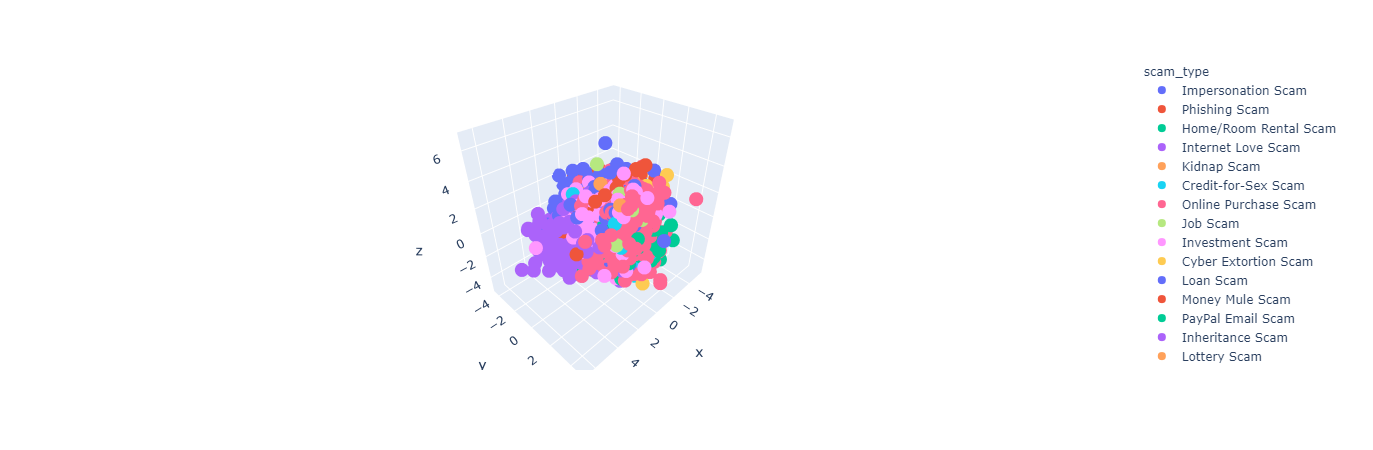

In [28]:
fig = px.scatter_3d(doc_pca_df, x='x', y='y', z='z',
              color='scam_type')
fig.show()

#### Visualisation of Document Embeddings of Top 3 Scam Types

In [29]:
doc_pca_df_subset = doc_pca_df[(doc_pca_df['scam_type'] == 'Impersonation Scam') | (doc_pca_df['scam_type'] == 'Online Purchase Scam') | (doc_pca_df['scam_type'] == 'Internet Love Scam')]
doc_pca_df_subset.head()

x         y         z           scam_type  \
0  -1.209759 -0.441699  0.467831  Impersonation Scam   
3  -2.215762 -1.616844  1.861302  Impersonation Scam   
6   1.870569 -0.237653 -0.268465  Internet Love Scam   
7   2.544057 -1.867145 -1.594340  Internet Love Scam   
10 -0.571035 -0.984236  1.812267  Impersonation Scam   

                                    preprocessed_text  
0   they call me by whatsapp it was strange<br> fo...  
3   details i received a call from what seemed<br>...  
6   this man is from china and claimed live<br> in...  
7   met online at inner circle dating app. said<br...  
10  on jul at. am, received a phone call<br> from ...

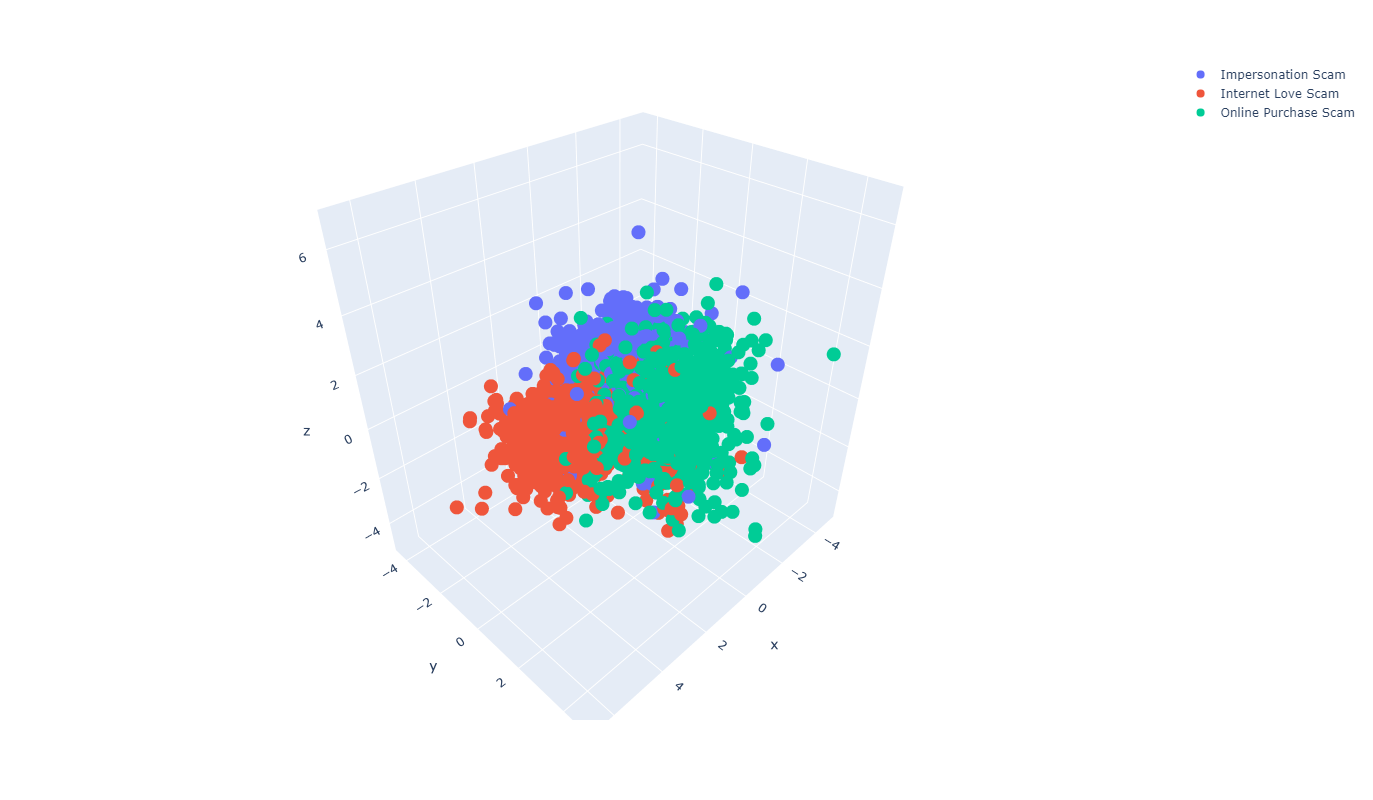

In [30]:
fig = px.scatter_3d(doc_pca_df_subset, x='x', y='y', z='z',
              color='scam_type', labels={"scam_type": ""}, hover_data=['preprocessed_text', 'scam_type'], width=1000, height=800)
fig.show()

#### Extraction of Similar Scam Reports

In [31]:
# Extract noun phrases in input text
get_noun_phrases(new_doc.lower())

['guy', 'christopher', 'tinder', 'dubai']

In [32]:
# Find scam reports similar to the new scam report and save them in a dataframe
x1 = find_similar_docs_cosine_jaccard(model=best_model, corpus=corpus, tag_id=None, new_doc=new_doc, top_n=len(df))

In [33]:
# Sort by cosine similarity in decreasing order
x2 = x1.sort_values(['cosine'], ascending=(False)).drop(columns="jaccard")

# Select top 0.5% most similar scam reports only
x3 = x2[x2['cosine'] >= x2.cosine.quantile(0.995)]

# Left join with scam type column
x4 = pd.merge(x3, tag_id_scam_type, how='left', on='tag_id')

# Display the top 20 scam reports 
print("Number of similar scam reports:", len(x4), "\n")
x4.head(20).style.set_properties(subset=['text'], **{'width': '600px'})

Number of similar scam reports: 23 



### Text-Based Approach

In [34]:
# Sort by jaccard similarity in decreasing order
x2 = x1.sort_values(['jaccard'], ascending=(False)).drop(columns="cosine")

# Select top 0.5% most similar scam reports only
x3 = x2[x2['jaccard'] >= x2.jaccard.quantile(0.995)]

# Left join with scam type column
x4 = pd.merge(x3, tag_id_scam_type, how='left', on='tag_id').reset_index()

# Display the top 20 scam reports 
print("Number of similar scam reports:", len(x4), "\n")
x4.head(20).style.set_properties(subset=['text'], **{'width': '600px'})

Number of similar scam reports: 29 



### Hybrid Approach

In [35]:
# Sort by jaccard and cosine similarities in decreasing order
x2 = x1.sort_values(['jaccard', 'cosine'], ascending=(False, False))

# Select top 20 most similar scam reports only
x3 = x2.head(20)
# x3 = x2[x2['jaccard'] >= x2.jaccard.quantile(0.995)]

# Left join with scam type column
x4 = pd.merge(x3, tag_id_scam_type, how='left', on='tag_id')

# Display the top 20 scam reports 
print("Number of similar scam reports:", len(x4), "\n")
x4.head(20).style.set_properties(subset=['text'], **{'width': '600px'})

Number of similar scam reports: 20 



## Generating Key Terms from Similar Scam Reports

To achieve this research goal, we use TF-IDF to extract unique words from a set of similar scam reports. We can explore either each of unigram, bigram and trigram, or a combination of them. Additionally, arranging them by median index positions and visualising them in sequence provides stronger intuition about how the scam typically happens.

In [36]:
# Define a list of additional stopwords to add
new_stopwords = ['ask', 'said', 'say', 'asked', 'claimed', 'told', 'got', 'tell', 'get']

# Add new stopwords into existing list
stop_words = stopwords.words('english')
for word in new_stopwords:
    stop_words.append(word) 

In [37]:
# Remove stopwords from the text of most similar documents
without_stopwords = documents_without_stopwords(list(x4.text))

### Extract unigrams

In [38]:
# Extract top 10 unigrams
t_df, ranking_df = extract_n_grams(doc_list=without_stopwords, n_min=1, n_max=1, top_n=10)
ranking_df

term  tfidf_score
146        guy     1.361586
317     tinder     1.312850
45        call     1.096755
223     number     0.924566
207        met     0.891579
285  singapore     0.767466
212      money     0.752310
356   whatsapp     0.704687
141       good     0.703896
0      account     0.691680

### Extract bigrams

In [39]:
# Extract top 10 bigrams
t_df, ranking_df = extract_n_grams(doc_list=without_stopwords, n_min=2, n_max=2, top_n=10)
ranking_df

term  tfidf_score
50              bought cards     0.426401
228               guy tinder     0.409995
92     checkpoints authority     0.400000
243  immigration checkpoints     0.400000
313                  met guy     0.390918
391            received call     0.390096
163              even called     0.382115
27             annoying hope     0.353553
42                bern times     0.353553
69              calling bern     0.353553

### Extract trigrams

In [40]:
# Extract top 10 trigrams
t_df, ranking_df = extract_n_grams(doc_list=without_stopwords, n_min=3, n_max=3, top_n=10)
ranking_df

term  tfidf_score
241  immigration checkpoints authority     0.426401
26                  annoying hope help     0.377964
41                 bern times annoying     0.377964
66                  calling bern times     0.377964
215                   guy keep calling     0.377964
235                     hope help find     0.377964
259                  keep calling bern     0.377964
466                times annoying hope     0.377964
207                   gut feelings guy     0.306008
34            article singapore police     0.301511

### Arrange n-grams by median index positions

In [41]:
# Top 20 unigrams arranged by median index positions
_, ngram_df = extract_n_grams(doc_list=without_stopwords, n_min=1, n_max=1, top_n=20)
ngram_df = arrange_n_grams_in_sequence(ngram_df).reset_index()
ngram_df = create_next_term_column(ngram_df)
ngram_df

index       term  next_term  tfidf_score sequence
0     207        met     tinder     0.891579        0
1     317     tinder        guy     1.312850       13
2     146        guy       like     1.361586       15
3     183       like       call     0.573650     23.5
4      45       call  singapore     1.096755       29
5     285  singapore      china     0.767466       39
6      64      china      cards     0.566768     55.5
7      50      cards      could     0.679328       58
8      82      could    account     0.555823     71.5
9       0    account       good     0.691680       72
10    141       good    chinese     0.703896       75
11     65    chinese   whatsapp     0.576035       81
12    356   whatsapp       help     0.704687       88
13    149       help     parcel     0.582461     88.5
14    232     parcel     called     0.629846       92
15     46     called     bought     0.559394    103.5
16     40     bought     number     0.588836    125.5
17    223     number       real     0.924566      131
18    254       real      money     0.563171      146
19    212      money                0.752310      194

### Visualise using directed graph

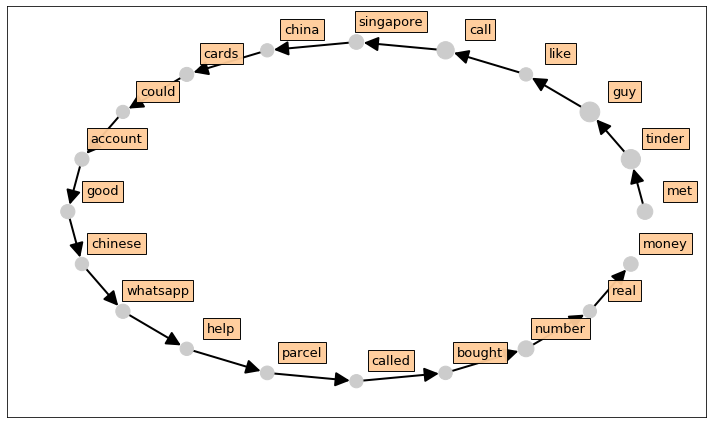

In [42]:
visualise_n_grams(ngram_df)

In [43]:
# similar_scams_df, ngrams_df = visualise_key_terms(new_doc, q=0.995, n_min=1, n_max=1, top_ng=20)

## Classifying Scam Report

To achieve this research goal, we explore two methods:
1. **Using Doc2Vec Model** - using document embeddings from a doc2vec model and the most popular classification amongst the nearest neighbours to a reference scam report; and
2. **Using Deep Learning Model** - using the trained model to predict classification of an unseen scam report (Refer to Python notebook titled `7.2 - Putting It All Together (Part 2)`).

### Using Doc2Vec Model

In [44]:
c1 = Counter(x4['scam_type'])
c2 = [(i, c1[i] / len(x3) * 100.0) for i in c1]

d1 = pd.DataFrame(dict(c1), index=[0]).transpose().reset_index()
d2 = pd.DataFrame(dict(c2), index=[0]).transpose().reset_index()

d = pd.merge(d1, d2, how='left', on='index')
d.columns = ['scam_type', 'count', 'perc']
d

scam_type  count  perc
0    Internet Love Scam     13  65.0
1       Investment Scam      2  10.0
2  Online Purchase Scam      2  10.0
3    Impersonation Scam      3  15.0

### Using Deep Learning Model

Refer to the Python notebook titled `7.2 - Putting It All Together (Part 2)`.

## Additional: Finding Similar Words

This additional section demonstrates how we can find similar words using a trained doc2vec model.

In [45]:
# Specify a word and find its similar words
word = 'ministry'
find_similar_words(model=best_model, corpus=corpus, word=word, top_n=10)

Word: inland
Similarity Score: 0.641577 

Word: citibank
Similarity Score: 0.578943 

Word: immigration
Similarity Score: 0.513833 

Word: revenue
Similarity Score: 0.511923 

Word: monetary
Similarity Score: 0.505385 

Word: worry
Similarity Score: 0.494487 

Word: assortment
Similarity Score: 0.483299 

Word: singtel
Similarity Score: 0.466068 

Word: agency
Similarity Score: 0.457138 

Word: false
Similarity Score: 0.457033 



In [46]:
# Specify a word and find its similar words
word = 'facebook'
find_similar_words(model=best_model, corpus=corpus, word=word, top_n=10)

Word: instagram
Similarity Score: 0.784381 

Word: carousell
Similarity Score: 0.766457 

Word: wechat
Similarity Score: 0.654821 

Word: okcupid
Similarity Score: 0.642530 

Word: linkedin
Similarity Score: 0.609665 

Word: whatsapp
Similarity Score: 0.602571 

Word: kik
Similarity Score: 0.589972 

Word: whatsapp..
Similarity Score: 0.589788 

Word: locanto
Similarity Score: 0.552142 

Word: lazada
Similarity Score: 0.528800 



In [47]:
# Specify a word and find its similar words
word = 'december'
find_similar_words(model=best_model, corpus=corpus, word=word, top_n=10)

Word: june
Similarity Score: 0.633106 

Word: august
Similarity Score: 0.632498 

Word: march
Similarity Score: 0.632202 

Word: april
Similarity Score: 0.614794 

Word: nov
Similarity Score: 0.601300 

Word: oct
Similarity Score: 0.594147 

Word: day
Similarity Score: 0.588394 

Word: jan
Similarity Score: 0.587717 

Word: feb
Similarity Score: 0.567105 

Word: november
Similarity Score: 0.565140 



In [48]:
# Specify a word and find its similar words
word = 'singapore'
find_similar_words(model=best_model, corpus=corpus, word=word, top_n=10)

Word: china
Similarity Score: 0.695106 

Word: london
Similarity Score: 0.664778 

Word: malaysia
Similarity Score: 0.641589 

Word: canada
Similarity Score: 0.610592 

Word: kuwait
Similarity Score: 0.573224 

Word: shanghai
Similarity Score: 0.532774 

Word: melbourne
Similarity Score: 0.530209 

Word: beijing
Similarity Score: 0.516903 

Word: headquarter
Similarity Score: 0.506027 

Word: florida
Similarity Score: 0.501644 



In [49]:
# Specify a word and find its similar words
word = 'olivia'
find_similar_words(model=best_model, corpus=corpus, word=word, top_n=10)

Word: translated
Similarity Score: 0.633800 

Word: heng
Similarity Score: 0.602901 

Word: wesley
Similarity Score: 0.585461 

Word: xu
Similarity Score: 0.581005 

Word: chen
Similarity Score: 0.566384 

Word: mathews
Similarity Score: 0.565718 

Word: persona
Similarity Score: 0.556882 

Word: executive
Similarity Score: 0.547822 

Word: zhen
Similarity Score: 0.546680 

Word: jack
Similarity Score: 0.545363 

